In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon
from tqdm.notebook import tqdm
import time
from datetime import datetime

import requests
import re
from bs4 import BeautifulSoup
import json
import urllib

In [12]:
transp_reg = gpd.read_file('./data/from/transp_reg_st.shp',
                        encoding='utf-8')
# transp_reg.crs = 'epsg:53004'
transp_reg = transp_reg.to_crs('epsg:4326')

In [25]:
def find_js(lnk):
    with requests.get(lnk, stream=True, timeout=25) as req:
        bs = BeautifulSoup(req.text, 'html.parser')
        all_scrpt = bs.find_all("script")
        for scr in all_scrpt:
            if scr.get('type') == "application/json":
                sc_ind = all_scrpt.index(scr)
                break
            else:
                sc_ind=0
        # 
        scrp_txt = all_scrpt[sc_ind].text
        js = json.loads(scrp_txt)

        return js

In [212]:
def get_poi(word, srch_pt, poly):

    str_qt = urllib.parse.quote(word)

    coords1 = str(str(srch_pt.coords[0][0]) + "%2C" + str(srch_pt.coords[0][1]))
    coords2 = coords1

    url = "https://yandex.ru/maps/51/samara/search/{str_qt}/?ll={coords1}&sll={coords2}&sspn=0.015134%2C0.006711&z=15.96".format(str_qt=str_qt,
                                                                                                                                       coords1=coords1,
                                                                                                                                       coords2=coords2)
    # 
    js = find_js(url)

    fnd_items = js['searchPreloadedResults']['items']

    if len(fnd_items) == 0:
        lst_res = [word+'_not_found', None, srch_pt]
    else:
        i=0
        for i in range(len(fnd_items)):
            fnd_pt = Point(fnd_items[i]['coordinates'])
            if poly.intersects(fnd_pt):
                name = fnd_items[0]['title']
                lst_res = [word, name, fnd_pt]
                break
            else:
                lst_res = [word+'_not_found', None, srch_pt]
    # 
    return lst_res

In [215]:
def get_reg_centre(reg, lst_words):

    poly = reg.geometry[0]
    srch_pt = poly.centroid
    reg_id = reg.NO[0]

    bg_lst_found = []
    i=0
    for i in range(len(lst_words)):
        word = lst_words[i]
        try:
            lst_res = [reg_id] + get_poi(word, srch_pt, poly)
        except:
            time.sleep(30)
            lst_res = [reg_id] + get_poi(word, srch_pt, poly)
        bg_lst_found.append(lst_res)
    # 
    return bg_lst_found

In [ ]:
def get_dist_n_time(js, tp_ts):

    if tp_ts == 'auto':
        distnc = round(js['routerResponse']['routes'][0]['distance']['value'] / 1000, 2)
        tm_avg = round(js['routerResponse']['routes'][0]['duration'] / 60, 1)
        tm_trfc = round(js['routerResponse']['routes'][0]['durationInTraffic'] / 60, 1)
    else:
        tm_avg = round(js['routerResponse']['routes'][0]['duration'] / 60, 1)
        distnc = None
        tm_trfc = None
    # 
    lst_dist_time = [distnc, tm_avg, tm_trfc]

    return lst_dist_time

In [89]:
def make_str_coords(one_reg_pt, two_reg_pt):
    coord_str = str(str(one_reg_pt.coords[0][1]) 
                    + "%2C" 
                    + str(one_reg_pt.coords[0][0]) 
                    + "~" 
                    + str(two_reg_pt.coords[0][1]) 
                    + "%2C" 
                    + str(two_reg_pt.coords[0][0]))
    # 
    return coord_str

In [138]:
lst_words = ['Торговый центр',
                'Железнодорожная станция',
                'Автостанция',
                'Площадь',
                'Больница',
                'ВУЗ',
                'Завод']

In [ ]:
bg_lst_pts = []

i=0
# for i in tqdm(range(2)):
for i in tqdm(range(len(transp_reg))):
    reg = transp_reg.iloc[[i]].reset_index(drop=True)
    bg_lst_found = get_reg_centre(reg, lst_words)
    bg_lst_pts = bg_lst_pts + bg_lst_found
# 

In [ ]:
clmns = ['reg_id', 'grp_pt', 'name_pt', 'geometry']
df = pd.DataFrame(bg_lst_pts, columns = clmns)
gdf_pts = gpd.GeoDataFrame(df, geometry='geometry')
gdf_pts.crs='epsg:4326'

In [ ]:
gdf_pts.to_file('./data/res/gdf_pts_all.json', driver='GeoJSON', encoding='utf-8')

In [206]:
lst_reg_id = [transp_reg.NO[0], transp_reg.NO[1]]
lst_total_data=[]

i=0
# for i in range(len()):
for i in range(1):
    one_reg_pt = transp_reg.geometry[i].centroid
    two_reg_pt = transp_reg.geometry[i+1].centroid
    coord_str = make_str_coords(one_reg_pt, two_reg_pt)
    
    # tp_ts_mt="mt"
    url_mt = "https://yandex.ru/maps/51/samara/?ll=50.131701%2C53.198707&mode=routes&rtext={}&rtt=mt&ruri=~&z=14.41". format(coord_str)
    # tp_ts_auto = "auto"
    url_auto = "https://yandex.ru/maps/51/samara/?ll=50.131701%2C53.198707&mode=routes&rtext={}&rtt=auto&ruri=~&z=14.41". format(coord_str)
    
    js_mt = find_js(url_mt)
    js_auto = find_js(url_auto)
    lst_dist_time_auto = get_dist_n_time(js_auto, 'auto')
    lst_dist_time_mt = get_dist_n_time(js_mt, 'mt')
    x_from = one_reg_pt.x
    y_from = one_reg_pt.y
    x_to = two_reg_pt.x
    y_to = two_reg_pt.y
    
    line_geo = LineString(js_auto['routerResponse']['routes'][0]['coordinates'])
    
    lst_one_data = [[lst_reg_id[i], lst_reg_id[i+1]] 
                    + lst_dist_time_auto 
                    + [lst_dist_time_mt[1]] + [x_from, y_from, x_to, y_to] + [line_geo]]
    lst_total_data = lst_total_data + lst_one_data
# 

In [207]:
lst_one_data

[[1,
  2,
  70.09,
  62.3,
  62.3,
  119.4,
  49.84801281250166,
  53.48099807074027,
  50.273238903939905,
  53.19362529820282,

In [ ]:
len()

In [208]:
clmns=['id_reg_from', 'id_reg_to', 'length', 'time_auto_avg', 
       'time_auto_traff', 'time_pubtr', 'x_from', 'y_from', 'x_to', 'y_to', 'geometry']
df_rt = pd.DataFrame(lst_one_data, columns = clmns)
gdf_rt = gpd.GeoDataFrame(df_rt, geometry='geometry')
gdf_rt.crs='epsg:4326'

In [209]:
gdf_rt

,id_reg_from,id_reg_to,length,time_auto_avg,time_auto_traff,time_pubtr,x_from,y_from,x_to,y_to,geometry
0,1,2,70.09,62.3,62.3,119.4,49.848013,53.480998,50.273239,53.193625,"LINESTRING (49.84795 53.48084, 49.84782 53.480..."


In [211]:
# gdf_rt.to_file('./data/res/gdf_rt.json', driver='GeoJSON', encoding='utf-8')

In [ ]:
# откуда, куда, расстояние, авто_время среднее, авто_время в пробках, 
# общтр_время среднее, точко откуда, точка куда

In [ ]:
# def get_geo(js):
# return line

In [154]:
# gdf_pts.to_file('./data/res/gdf_pts.json', driver='GeoJSON', encoding='utf-8')

In [158]:
js_auto.keys()

dict_keys(['counters', 'hosts', 'locale', 'lang', 'tld', 'query', 'baseUrl', 'originalUrl', 'uatraits', 'cspNonce', 'origin', 'csrfToken', 'xscriptCsrfToken', 'isUserFromPortal', 'isUserFromGoogle', 'availableLangs', 'currencyCode', 'banner', 'staticHost', 'pageMode', 'bookmarks', 'clientErrors', 'searchResultsCount', 'enableTaxi', 'enableAvia', 'enableZapravkiPromo', 'iframeCounter', 'tnsCounter', 'cloudApi', 'blaBlaCarBanner', 'search', 'routes', 'feedback', 'font', 'advert', 'serviceName', 'bilet', 'share', 'mobile', 'servicePanel', 'apiManual', 'mapMargin', 'business', 'troubleshooting', 'passport', 'morda', 'ruler', 'ugcCabinet', 'advertLandingUrl', 'advertLandingMetroUrl', 'becomeAuthorUrl', 'becomeOwnerUrl', 'agreementUrl', 'metroAgreementUrl', 'rightHoldersUrl', 'ymapsUrlTemplate', 'commentatorWidget', 'mrcLandingUrl', 'reviews', 'enableRoutesB2B', 'routesB2BUrl', 'enableMobileDistribution', 'bannerLayout', 'pharmacyLinks', 'mapLocation', 'mapType', 'userRegion', 'experiments',

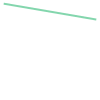

In [191]:
i=0
lst_segms = js_auto['routerResponse']['routes'][0]['paths'][0]['segments']
one_segm = lst_segms[i]
LineString(one_segm['edgePoints'])

In [194]:
lst_segms = js_auto['routerResponse']['routes'][0]['paths'][0]['segments']
rt_line=[]
line_data=[]

i=0
for i in range(len(lst_segms)):
    one_segm = lst_segms[i]
    line_segm = LineString(one_segm['edgePoints'])
    rt_line.append(line_segm)
# 
line_data.append(MultiLineString(rt_line))

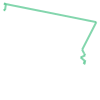

In [195]:
line_data[0]

In [196]:
one_segm = gpd.GeoDataFrame(geometry=line_data)
one_segm.crs='epsg:4326'

In [178]:
print(url_auto)

https://yandex.ru/maps/51/samara/?ll=50.131701%2C53.198707&mode=routes&rtext=53.48099807074027%2C49.84801281250166~53.19362529820282%2C50.273238903939905&rtt=auto&ruri=~&z=14.41


In [ ]:
# one_part = one_dir[i]['points']
# rt_line.append(LineString(one_part))
# line_data.append(MultiLineString(rt_line))

In [197]:
one_segm.to_file('./data/res/one_segm.json', driver='GeoJSON', encoding='utf-8')

In [198]:
js_auto['routerResponse']['routes'][0]['paths'][0].keys()

dict_keys(['segments', 'bounds', 'endTime', 'beginTime'])

In [200]:
js_auto['routerResponse']['routes'][0].keys()

dict_keys(['uuid', 'type', 'paths', 'refPointsLineCoordinates', 'constructions', 'distance', 'duration', 'durationInTraffic', 'bounds', 'encodedCoordinates', 'flags', 'colorizeInfo', 'matchFilter', 'arrivalValue', 'coordinates'])

In [ ]:
# arrivalValue

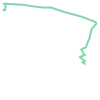

In [202]:
line_geo = LineString(js_auto['routerResponse']['routes'][0]['coordinates'])